GPT Vision Notebook / Shriya Natarajan

GPT-Vision-invasive-plants.ipynb / https://colab.research.google.com/drive/117xvg6u9BoO2YQ2mjArxJcJgdO-7N6ac


In [ ]:
pip install httpx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00


In [ ]:
pip install google.generativeai

In [ ]:
import pathlib
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown
import urllib.request
from PIL import Image
import base64
import httpx

In [ ]:
from google.colab import drive
import pandas as pd
import json
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from google.colab import userdata


In [ ]:
genai.configure(api_key=userdata.get('GOOGLE_KEY'))



In [ ]:
# Check the code from current notebook
drive.mount('/content/gdrive')

#Change the path below to the file path
images = pd.read_csv('gdrive/My Drive/New Image CSV/NEWAll_Plants_Gemini_flash.csv', encoding= 'unicode_escape')
len(images)

Mounted at /content/gdrive


2500

In [ ]:
#Check the top rows
images.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,plant_name,image_url,latitude,longitude,profile_url,predicted_label,LLMLabels
0,0,0,0,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,37.318328,-93.295312,https://www.inaturalist.org/observations/20492...,Japanese Barberry,Japanese Barberry
1,1,1,1,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,38.700655,-90.721412,https://www.inaturalist.org/observations/20493...,Japanese Barberry,Japanese Barberry
2,2,2,2,Autumn Olive,https://static.inaturalist.org/photos/36228599...,38.830053,-94.744653,https://www.inaturalist.org/observations/20493...,Japanese Knotweed,Japanese Knotweed
3,3,3,3,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.596591,-82.306213,https://www.inaturalist.org/observations/20493...,Japanese Barberry,Japanese Barberry
4,4,4,4,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.217080,-85.134268,https://www.inaturalist.org/observations/20493...,Japanese Knotweed,Japanese Knotweed


In [ ]:
zero_shot_sys = '''You are designed to detect if the attached image of a plant has an one of 10 plant species.

The list of 10  species we are interested in are Autumn Olive, Black Swallow Wort, Common Reed, Garlic Mustard, Japanese Barberry, Japanese Knotweed, Mile a minute, Mugwort, Multiflora rose, and Oriental Bittersweet

You will return a JSON indicating the plant most likely in the picture if any and the probability like this {"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"}

Please do not include any text other than the JSON response.'''


zero_shot_prompt='''Is  one of the  10 plants in this image?'''

In [ ]:
client = genai.GenerativeModel(model_name='gemini-1.5-flash',system_instruction=zero_shot_sys)

In [ ]:
# Helper function to ChatGPT and get the JSON response.
def json_gemini(sys_prompt: str, user_prompt: str, image_url: str):
  try:
        #print(image_url)
        image_data = base64.b64encode(httpx.get(image_url).content).decode("utf-8")
        #print("got it")
        messages=[user_prompt, image_data]

         #[{"parts":[{"inlineData": {"mimeType": "image/jpeg","data": image_data}},
          #          {"text": user_prompt}],"role": "user"}]

        content = {"contents":messages,"systemInstruction":sys_prompt}
        #print(messages)
        completion = client.generate_content(messages)

        #print(completion)
        text = completion.candidates[0].content.parts[0].text
        print(text)
        parsed = json.loads(text)

        return parsed
  except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#images['predicted_label'] = None


In [ ]:
images.to_csv('gdrive/My Drive/New Image CSV/NEWAll_Plants_Gemini_flash.csv', encoding= 'unicode_escape')
#images = pd.read_csv('gdrive/My Drive/New Image CSV/NEWAll_Plants.csv', encoding= 'unicode_escape')
#len(images)

In [ ]:
# Assuming 'images' DataFrame already exists
# Add a column for predicted labels to the DataFrame

for i, row in images.head(2500).iterrows():
  pred_lbl = images.at[i, 'predicted_label']
  if  pred_lbl is None or pd.isna(pred_lbl):
    print("Processing:", i, row["plant_name"], row["image_url"])
    result = json_gemini(zero_shot_sys, zero_shot_prompt, row["image_url"])
    if result:
        print("Result:", result)
        # Use result.get with a default value of "Unknown" for cases where the model returns no prediction
        plant_name = result.get("plant_name", None)
        if not plant_name:  # This checks for both None and empty string cases
            plant_name = "Unknown"
        images.at[i, 'predicted_label'] = plant_name
    else:
        print("Failed to get a result.")
        images.at[i, 'predicted_label'] = "Unknown"  # Handle failed predictions


Processing: 749 Common Reed https://inaturalist-open-data.s3.amazonaws.com/photos/365980284/medium.jpeg 
{"found_plant":"no", "plant_name":"None", "probability":"0"} 

Result: {'found_plant': 'no', 'plant_name': 'None', 'probability': '0'}
Processing: 1976 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367096042/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1246.78ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 1977 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367147297/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1221.58ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 1978 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367165772/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 1979 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367172811/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 1980 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367199674/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Resul

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1217.94ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 1986 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367271025/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 1987 Mugwort https://static.inaturalist.org/photos/367278982/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 1988 Mugwort https://inaturalist-open-data.s3.amazonaws.com/photos/367287411/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"}
Result: {'found_plant': 

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1017.70ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2006 Multiflora Rose https://static.inaturalist.org/photos/362388461/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2007 Multiflora Rose https://static.inaturalist.org/photos/362401360/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2008 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/362424590/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 967.14ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2011 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/362637521/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2012 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363131832/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2013 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/362817251/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "pro

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1019.79ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2031 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363000529/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".98"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.98'}
Processing: 2032 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363011853/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2033 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/362986600/medium.jpeg
{"found_plant":"yes", "plant_name":"Multiflora rose", "pr

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 915.00ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2036 Multiflora Rose https://static.inaturalist.org/photos/363071185/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2037 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363102729/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1227.90ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2038 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363117274/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 969.67ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2039 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363120299/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2040 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363137001/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2041 Multiflora Rose https://static.inaturalist.org/photos/363210333/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 



ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1301.13ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2056 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363516700/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2057 Multiflora Rose https://static.inaturalist.org/photos/363519922/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1373.23ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2058 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363523084/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2059 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363525374/medium.jpeg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2060 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363545427/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probab

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1651.45ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2065 Multiflora Rose https://static.inaturalist.org/photos/363700699/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2066 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363676526/medium.jpeg
{"found_plant":"no", "plant_name":"null", "probability":"null"} 

Result: {'found_plant': 'no', 'plant_name': 'null', 'probability': 'null'}
Processing: 2067 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363685125/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plan

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1091.53ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2075 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363848338/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1475.23ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2076 Multiflora Rose https://static.inaturalist.org/photos/363891668/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2077 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363900641/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2078 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/363914005/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 



ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1017.99ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2096 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364470491/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2097 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364485679/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".98"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.98'}
Processing: 2098 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364532472/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1156.19ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2110 Multiflora Rose https://static.inaturalist.org/photos/364665771/medium.jpeg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2111 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364678292/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2112 Multiflora Rose https://static.inaturalist.org/photos/364688861/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1178.48ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2120 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364879934/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2121 Multiflora Rose https://static.inaturalist.org/photos/364880093/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2122 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/364886422/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1145.16ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2147 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365357454/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2148 Multiflora Rose https://static.inaturalist.org/photos/365357758/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2149 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365357807/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1051.51ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2167 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365510759/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1117.25ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2168 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365530699/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2169 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365531980/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2170 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365542656/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probab

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1016.30ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2172 Multiflora Rose https://static.inaturalist.org/photos/365692862/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2173 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366143684/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2174 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366506363/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1248.27ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2178 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365867141/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2179 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365871954/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2180 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/365992998/medium.jpeg
{"found_plant":"yes", "plant_name":"Multiflora rose", "p

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1297.08ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2194 Multiflora Rose https://static.inaturalist.org/photos/366242533/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2195 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366262440/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1221.59ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2196 Multiflora Rose https://static.inaturalist.org/photos/366262544/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2197 Multiflora Rose https://static.inaturalist.org/photos/366289120/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2198 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366298640/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1372.79ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2199 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366306879/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2200 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366448931/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2201 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/366462970/medium.jpeg
{"found_plant":"yes", "plant_name":"Autumn Olive", "proba

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1225.23ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2209 Multiflora Rose https://static.inaturalist.org/photos/366529182/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".98"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.98'}
Processing: 2210 Multiflora Rose https://static.inaturalist.org/photos/366541609/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2211 Multiflora Rose https://static.inaturalist.org/photos/366584273/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'ye

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 823.87ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2225 Multiflora Rose https://static.inaturalist.org/photos/367007134/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 734.40ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2226 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367025234/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2227 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367040557/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2228 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367042374/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "pro

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 763.79ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2240 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367183224/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2241 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367193784/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2242 Multiflora Rose https://inaturalist-open-data.s3.amazonaws.com/photos/367194193/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", 

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 838.98ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2251 Oriental Bittersweet https://static.inaturalist.org/photos/362614657/medium.jpg
{"found_plant":"yes", "plant_name":"Autumn Olive", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Autumn Olive', 'probability': '.95'}
Processing: 2252 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/362698308/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2253 Oriental Bittersweet https://static.inaturalist.org/photos/362781281/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1027.56ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2272 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/365262537/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".99"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.99'}
Processing: 2273 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/365391017/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2274 Oriental Bittersweet https://static.inaturalist.org/photos/365426329/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "pro

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1119.30ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2300 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/367307808/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2301 Oriental Bittersweet https://static.inaturalist.org/photos/367804120/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2302 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/367818610/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "pr

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1372.72ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2322 Oriental Bittersweet https://static.inaturalist.org/photos/369556754/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2323 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/369629763/medium.jpeg


ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 993.02ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2324 Oriental Bittersweet https://static.inaturalist.org/photos/369759825/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2325 Oriental Bittersweet https://static.inaturalist.org/photos/369792643/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".98"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.98'}
Processing: 2326 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/369807825/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 890.20ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2355 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/370929607/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2356 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/370934773/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2357 Oriental Bittersweet https://static.inaturalist.org/photos/370954465/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "prob

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 992.67ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2367 Oriental Bittersweet https://static.inaturalist.org/photos/371090068/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2368 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371097575/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2369 Oriental Bittersweet https://static.inaturalist.org/photos/371123387/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"}
R

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1184.35ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2371 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371139394/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2372 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371151069/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".99"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.99'}
Processing: 2373 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371162285/medium.jpeg
{"found_plant":"yes", "plant_name":"Multifl

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1551.38ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2393 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371295455/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2394 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371323908/medium.jpeg
{"found_plant":"yes", "plant_name":"Multiflora rose", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Multiflora rose', 'probability': '.95'}
Processing: 2395 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371326169/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Kn

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1016.60ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2406 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371447421/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2407 Oriental Bittersweet https://static.inaturalist.org/photos/371481397/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2408 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371659848/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "pro

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1118.50ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2415 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371753934/medium.jpg
{"found_plant":"yes", "plant_name":"Autumn Olive", "probability":".99"} 

Result: {'found_plant': 'yes', 'plant_name': 'Autumn Olive', 'probability': '.99'}
Processing: 2416 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371764398/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2417 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371764939/medium.jpg
{"found_plant":"yes", "plant_name":"Autumn Olive", "pr

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 1278.54ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2424 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371820662/medium.jpg
{"found_plant":"yes", "plant_name":"Autumn Olive", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Autumn Olive', 'probability': '.95'}
Processing: 2425 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/373228554/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2426 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371841812/medium.jpg
{"found_plant":"yes", "plant_name":"Multiflora rose",

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 816.64ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2445 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371927676/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2446 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/371930484/medium.jpeg
{"found_plant":"yes", "plant_name":"Autumn Olive", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Autumn Olive', 'probability': '.95'}
Processing: 2447 Oriental Bittersweet https://static.inaturalist.org/photos/371934632/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 916.95ms


Error: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting
Failed to get a result.
Processing: 2470 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/372230095/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Knotweed", "probability":".95"} 

Result: {'found_plant': 'yes', 'plant_name': 'Japanese Knotweed', 'probability': '.95'}
Processing: 2471 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/372239272/medium.jpg
{"found_plant":"yes", "plant_name":"Japanese Barberry", "probability":".95"}
Result: {'found_plant': 'yes', 'plant_name': 'Japanese Barberry', 'probability': '.95'}
Processing: 2472 Oriental Bittersweet https://inaturalist-open-data.s3.amazonaws.com/photos/372243465/medium.jpeg
{"found_plant":"yes", "plant_name":"Japanese 

In [ ]:
images['LLMLabels'] = images['predicted_label']
images

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,plant_name,image_url,latitude,longitude,profile_url,predicted_label,LLMLabels
0,0,0,0,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,37.318328,-93.295312,https://www.inaturalist.org/observations/20492...,Japanese Barberry,Japanese Barberry
1,1,1,1,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,38.700655,-90.721412,https://www.inaturalist.org/observations/20493...,Japanese Barberry,Japanese Barberry
2,2,2,2,Autumn Olive,https://static.inaturalist.org/photos/36228599...,38.830053,-94.744653,https://www.inaturalist.org/observations/20493...,Japanese Knotweed,Japanese Knotweed
3,3,3,3,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.596591,-82.306213,https://www.inaturalist.org/observations/20493...,Japanese Barberry,Japanese Barberry
4,4,4,4,Autumn Olive,https://inaturalist-open-data.s3.amazonaws.com...,35.217080,-85.134268,https://www.inaturalist.org/observations/20493...,Japanese Knotweed,Japanese Knotweed
...,...,...,...,...,...,...,...,...,...,...
2495,2495,2495,2495,Oriental Bittersweet,https://inaturalist-open-data.s3.amazonaws.com...,40.429848,-80.021935,https://www.inaturalist.org/observations/21086...,Japanese Knotweed,Japanese Knotweed
2496,2496,2496,2496,Oriental Bittersweet,https://inaturalist-open-data.s3.amazonaws.com...,35.610595,-82.831362,https://www.inaturalist.org/observations/21086...,Japanese Knotweed,Japanese Knotweed
2497,2497,2497,2497,Oriental Bittersweet,https://static.inaturalist.org/photos/37290083...,38.956869,-77.049470,https://www.inaturalist.org/observations/21086...,Japanese Knotweed,Japanese Knotweed
2498,2498,2498,2498,Oriental Bittersweet,https://static.inaturalist.org/photos/37290096...,38.956869,-77.049470,https://www.inaturalist.org/observations/21086...,Japanese Knotweed,Japanese Knotweed


In [ ]:

# Initialize LabelEncoder
le = LabelEncoder()
image_predict = images.head(2500)

for i, row in image_predict.iterrows():
  if images.at[i, 'predicted_label'] == None:
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'none':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Multiflora rose':
      images.at[i, 'predicted_label'] = 'Multiflora Rose'
  if images.at[i, 'predicted_label'] == 'Mile a minute':
      images.at[i, 'predicted_label'] = 'Mile A Minute'
  if images.at[i, 'predicted_label'] == 'Mile M Minute':
      images.at[i, 'predicted_label'] = 'Mile A Minute'
  if images.at[i, 'predicted_label'] == 'Japanese Honeysuckle':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Unkown':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Mile A Minute':
      images.at[i, 'predicted_label'] = 'Mile-A-Minute'
  if images.at[i, 'predicted_label'] == 'unknown':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Honeysuckle':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Olive':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'common reed':
      images.at[i, 'predicted_label'] = 'Common Reed'
  if images.at[i, 'predicted_label'] == 'N/A':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'n/a':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None of the 10 listed plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Ground ivy':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Garlic mustard':
      images.at[i, 'predicted_label'] = 'Garlic Mustard'
  if images.at[i, 'predicted_label'] == 'not found':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Wintergreen':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Goji berry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Forsythia':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Barberry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Japanese barberry':
      images.at[i, 'predicted_label'] = 'Japanese Barberry'
  if images.at[i, 'predicted_label'] == 'Clover':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Skunk cabbage':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Skunk Cabbage':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Japanese knotweed':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None of the 10 specified plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'none of the 10 specified plants':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'not identified':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Moss':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Fern':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Common Nightshade':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'English Ivy':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Porcelain-berry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Porcelain berry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'none of the 10 species':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'None of the 10 species':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Russian Olive':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Phragmites':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'Japonese Barberry':
      images.at[i, 'predicted_label'] = 'Japanese Barberry'
  if images.at[i, 'predicted_label'] == 'Porcelain Berry':
      images.at[i, 'predicted_label'] = 'Unknown'
  if images.at[i, 'predicted_label'] == 'null':
      images.at[i, 'predicted_label'] = 'Unknown'


# Collect unique plant names from the 'plant_name' column
unique_plant_names = images['plant_name'].unique().tolist()

# Ensure "Unknown" is included in the list of unique plant names
if "Unknown" not in unique_plant_names:
    unique_plant_names.append("Unknown")

# Fit the LabelEncoder with this updated list of plant names
le.fit(unique_plant_names)

print(unique_plant_names)
print(image_predict['plant_name'].unique())

print(image_predict['predicted_label'].unique())

# Transform the actual plant names to their encoded values
image_predict['actual_encoded'] = le.transform(image_predict['plant_name'])

# Transform the predicted labels to their encoded values
# This step now works correctly because "Unknown" is recognized by the encoder
image_predict['predicted_encoded'] = le.transform(image_predict['predicted_label'])


['Autumn Olive', 'Black Swallow Wort', 'Common Reed', 'Garlic Mustard', 'Japanese Barberry', 'Japanese Knotweed', 'Mile-A-Minute', 'Mugwort', 'Multiflora Rose', 'Oriental Bittersweet', 'Unknown']
['Autumn Olive' 'Black Swallow Wort' 'Common Reed' 'Garlic Mustard'
 'Japanese Barberry' 'Japanese Knotweed' 'Mile-A-Minute' 'Mugwort'
 'Multiflora Rose' 'Oriental Bittersweet']
['Japanese Barberry' 'Japanese Knotweed' 'Multiflora Rose' 'Unknown'
 'Autumn Olive' 'Oriental Bittersweet' 'Garlic Mustard']


<ipython-input-15-ce04fb721af9>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_predict['actual_encoded'] = le.transform(image_predict['plant_name'])
<ipython-input-15-ce04fb721af9>:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_predict['predicted_encoded'] = le.transform(image_predict['predicted_label'])


In [ ]:
print(image_predict)

      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0            plant_name  \
0                0             0           0          Autumn Olive   
1                1             1           1          Autumn Olive   
2                2             2           2          Autumn Olive   
3                3             3           3          Autumn Olive   
4                4             4           4          Autumn Olive   
...            ...           ...         ...                   ...   
2495          2495          2495        2495  Oriental Bittersweet   
2496          2496          2496        2496  Oriental Bittersweet   
2497          2497          2497        2497  Oriental Bittersweet   
2498          2498          2498        2498  Oriental Bittersweet   
2499          2499          2499        2499  Oriental Bittersweet   

                                              image_url   latitude  longitude  \
0     https://inaturalist-open-data.s3.amazonaws.com...  37.318328 -93.295312 

In [ ]:
print(image_predict['actual_encoded'])

0       0
1       0
2       0
3       0
4       0
       ..
2495    9
2496    9
2497    9
2498    9
2499    9
Name: actual_encoded, Length: 2500, dtype: int64


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(image_predict['actual_encoded'], image_predict['predicted_encoded'])
print(f"Accuracy: {accuracy}")

Accuracy: 0.0896


In [ ]:
# Confusion Matrix
cm = confusion_matrix(image_predict['actual_encoded'], image_predict['predicted_encoded'])
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 27   0   0   1  44 123   0   0  29   1  25]
 [ 23   0   0   0  39 140   0   0  29   0  19]
 [ 24   0   0   1  35 123   0   0  39   0  28]
 [ 29   0   0   0  27 128   0   0  41   0  25]
 [ 26   0   0   2  32 143   0   0  28   0  19]
 [ 16   0   0   0  44 125   0   0  34   0  31]
 [ 23   0   0   0  38 137   0   0  32   0  20]
 [ 21   0   0   1  28 131   0   0  27   0  42]
 [ 13   0   0   1  39 130   0   0  40   0  27]
 [ 25   0   0   0  33 146   0   0  31   0  15]
 [  0   0   0   0   0   0   0   0   0   0   0]]


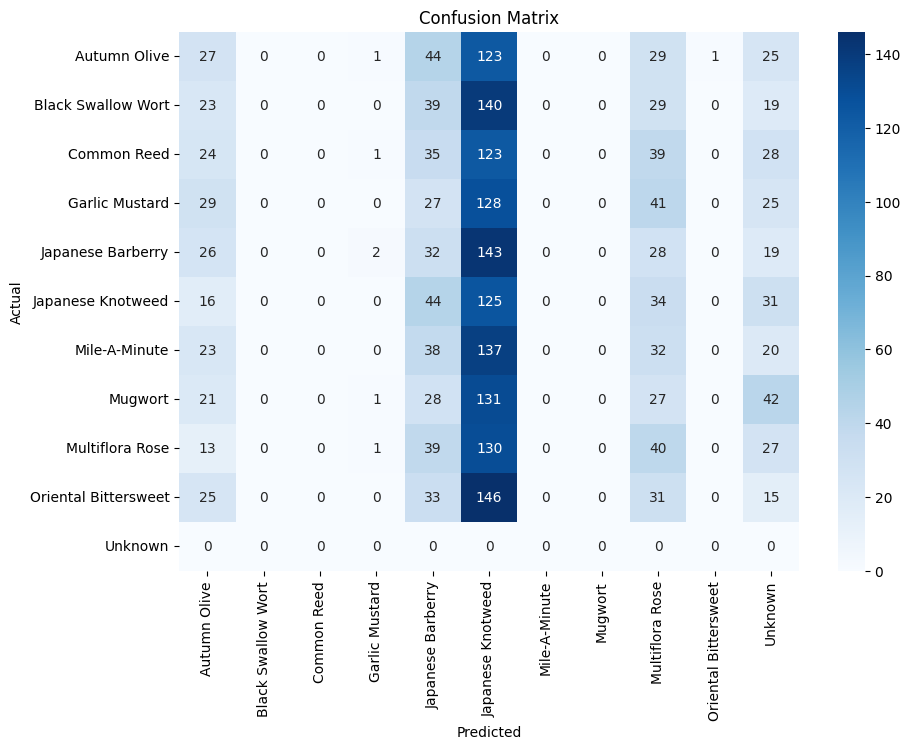

In [ ]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

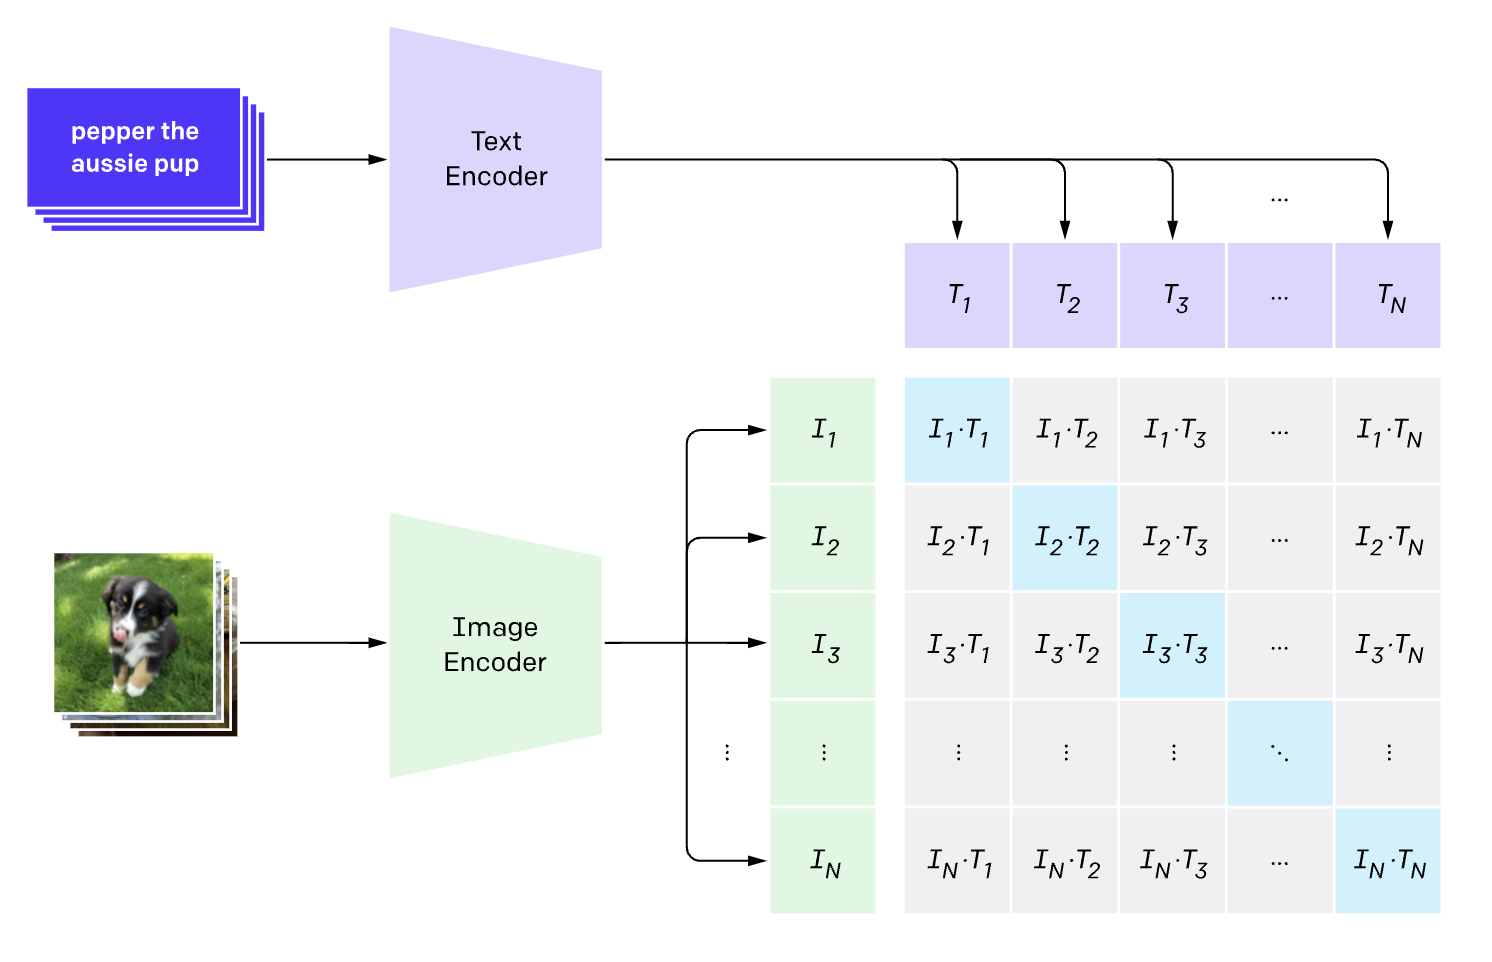

In [ ]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()